In [1]:
# used for manipulating directory paths
import os
import csv
import time

# Scientific and vector computation for python
import numpy as np
from numpy import linalg as la

# Plotting library
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# tells matplotlib to embed plots within the notebook
%matplotlib inline

import cv2

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA
from sklearn import manifold, datasets, cluster, preprocessing
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV,RepeatedKFold,learning_curve,ShuffleSplit
from sklearn.preprocessing import StandardScaler
import csv

In [2]:
def write_image(filename,img):
    cv2.imwrite(filename,img)

In [3]:
def sample_data(data,labels,count):
    numbers_list = []
    labels_list = []
    for i in range(10):
        arr = data[np.where(labels == i)]
        idx = np.random.choice(arr.shape[0],count,replace=False)
        numbers_list.append(arr[idx])
        labels_list.append(np.full(count,i,dtype=int))
        
    sub_data = np.array(numbers_list).reshape(count*10,784)    
    sub_labels = np.array(labels_list).reshape(count*10,)     
    return (sub_data,sub_labels)

In [4]:
def hog_extract(X,orientations,ppc,cpb,norm):
    hog_features = []
    for row in X:
        fd = hog(row.reshape(28,28), orientations=orientations, pixels_per_cell=ppc,cells_per_block=cpb,block_norm=norm)
        hog_features.append(fd)
    return np.array(hog_features)

In [5]:
#load data
data_path = os.path.join('C:/Users/Brett/Documents/CISC484/data/','train.csv')
with open(data_path) as f:
    #determining number of columns from the first line of text
    n_cols = len(f.readline().split(","))
    
data = np.loadtxt(data_path, delimiter=',',skiprows=1,usecols=np.arange(1, n_cols))
labels = np.loadtxt(data_path, delimiter=',',skiprows=1,usecols=0)

In [6]:
print("Shape of Data - {0}".format(data.shape))
print("Shape of Labels - {0}".format(labels.shape))
unique, counts = np.unique(labels, return_counts=True)
print("\nNumber\tCount")
for d, c in zip(unique, counts):
    print("{0}\t{1}".format(int(d),c))

Shape of Data - (42000, 784)
Shape of Labels - (42000,)

Number	Count
0	4132
1	4684
2	4177
3	4351
4	4072
5	3795
6	4137
7	4401
8	4063
9	4188


# -----------------------------------------------------------------------------------------------------------

In [34]:
x,y = sample_data(data,labels,1)
picture = []
for i in range(10):
    image = x[np.where(y == i)][0].reshape(28,28)
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    image8bit = cv2.resize(image8bit,(64,64))
    picture.append(image8bit)
write_image('numbers.jpg',np.vstack((np.hstack(np.array(picture)[0:5]),np.hstack(np.array(picture)[5:10]))))

picture = []
for i in range(10):
    image = x[np.where(y == i)][0].reshape(28,28)
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    image8bit = cv2.resize(image8bit,(128,128))
    fd,hog_image = hog(image8bit, orientations=9, pixels_per_cell=(8,8),cells_per_block=(2,2),block_norm= 'L2',visualize=True)
    hog_image*=3
    picture.append(hog_image)
write_image('numbers_hog.jpg',np.vstack((np.hstack(np.array(picture)[0:5]),np.hstack(np.array(picture)[5:10]))))

# -----------------------------------------------------------------------------------------------------------

In [8]:
x,y = sample_data(data,labels,250)

In [ ]:
x_features = hog_extract(x,9,(4,4),(2,2),'L2')

In [35]:
clusters = 150

sift = cv2.xfeatures2d.SIFT_create()
sift_descriptors = []
for row in training_data:
    image8bit = cv2.normalize(row.reshape(28,28), None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    kp, des = sift.detectAndCompute(image8bit,None)
    if (des is None):
        des = [np.zeros((128,), np.float32)]
    for x in des:
        sift_descriptors.append(x)
kmeans = cluster.KMeans(n_clusters=clusters).fit(np.array(sift_descriptors))

In [36]:
sift_features = []
for row in training_data:
    image8bit = cv2.normalize(row.reshape(28,28), None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    kp, des = sift.detectAndCompute(image8bit, None)
    histogram = np.zeros(clusters)
    
    if (des is None):
        des = np.zeros((1,128), np.float32)
    for x in des:
        idx = kmeans.predict([x])
        histogram[idx] += 1
    sift_features.append(histogram)

ValueError: Buffer dtype mismatch, expected 'double' but got 'float'

# -----------------------------------------------------------------------------------------------------------

In [46]:
rand_idx = np.arange(data.shape[0])
np.random.shuffle(rand_idx)

training_data = data[rand_idx][0:1000]
training_data_hog = hog_extract(training_data,9,(4,4),(2,2),'L2')
training_labels = labels[rand_idx][0:1000]

X_orig = training_data
X_train = training_data_hog
y_train = training_labels

In [23]:
def pca(X,k):
    #SVD
    Xc = X - np.mean(X, axis=0)
    U,S,VT = la.svd(Xc,full_matrices=False)
    S=S**2
      
    if (k is None):
        PC_k = VT[0:k,:].T
    else:
        PC_k = VT.T
    #project
    return Xc.dot(PC_k)

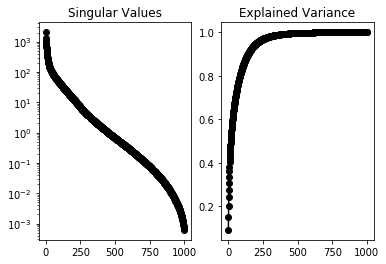

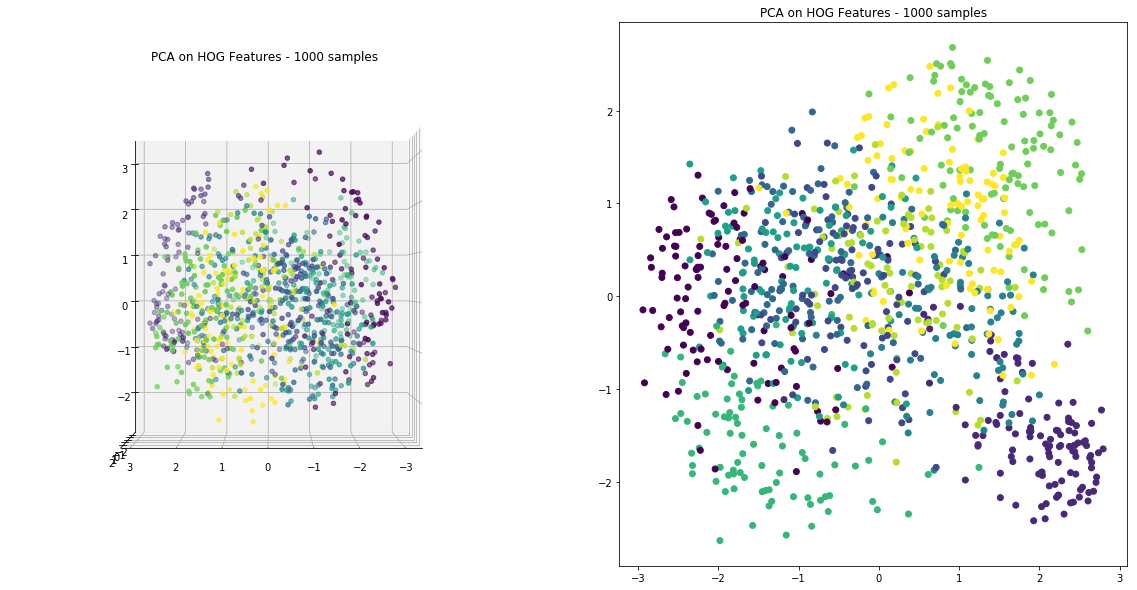

In [42]:
#SVD
Xc = X_train - np.mean(X_train, axis=0)
U,S,VT = la.svd(Xc,full_matrices=True)
S=S**2
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title('Singular Values')
ax1.semilogy(S[:-1],'-o',color='k')
ax2 = fig.add_subplot(122)
ax2.set_title('Explained Variance')
ax2.plot(np.cumsum(S)/np.sum(S),'-o',color='k')
plt.show()


PC_k = VT.T
#project
X_proj = Xc.dot(PC_k)

fig2 = plt.figure(figsize=(20,10))

ax = fig2.add_subplot(1,2,1, projection='3d')
ax2 = fig2.add_subplot(1,2,2)
ax.scatter(X_proj[:,0], X_proj[:,1], X_proj[:,2],c=y_train.reshape(len(y_train),))
ax2.scatter(X_proj[:,0], X_proj[:,1],c=y_train.reshape(len(y_train),))
ax.set_title('PCA on HOG Features - 1000 samples')
ax2.set_title('PCA on HOG Features - 1000 samples')
ax.view_init(0,90)

In [20]:
picture = []
for idx in range(15):
    image = PC_k[idx].reshape(28,28)
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    image8bit = cv2.resize(image8bit,(64,64))
    picture.append(image8bit)
write_image('pca.jpg',np.vstack((np.hstack(np.array(picture)[0:5]),
                                      np.hstack(np.array(picture)[5:10]),
                                      np.hstack(np.array(picture)[10:15]))))

In [47]:
X_tsne = manifold.TSNE(n_components=3,perplexity=25).fit_transform(X_train)

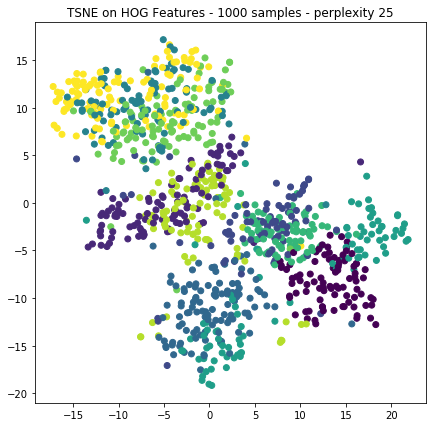

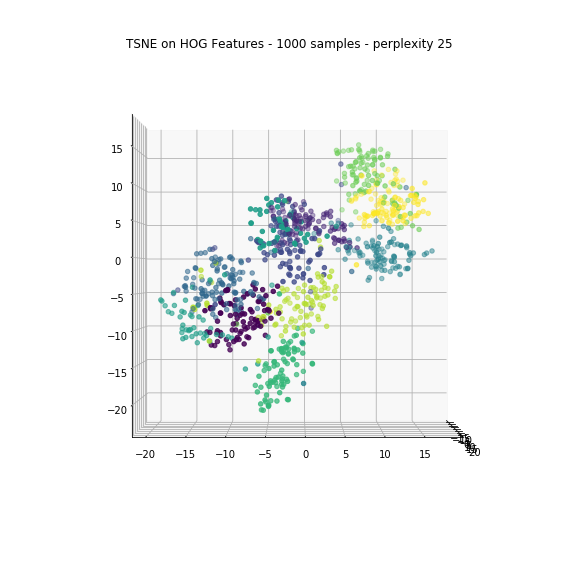

In [48]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
ax.scatter(X_tsne[:,0], X_tsne[:,1],c=y_train.reshape(len(y_train),))
ax.set_title('TSNE on HOG Features - 1000 samples - perplexity 25')
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2],c=y_train.reshape(len(y_train),))
ax.set_title('TSNE on HOG Features - 1000 samples - perplexity 25')
ax.view_init(0,0)

plt.show()

In [63]:
idxs = np.where((X_tsne[:,0]>3) & (X_tsne[:,0]<4.6) & (X_tsne[:,1]>2) & (X_tsne[:,1]<8))
idxs

(array([156, 594, 718, 744], dtype=int64),)

In [64]:
picture = []
for idx in idxs[0]:
    image = X_orig[idx].reshape(28,28)
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    image8bit = cv2.resize(image8bit,(64,64))
    picture.append(image8bit)
write_image('outliers2.jpg',np.hstack(np.array(picture)[0:4]))
pass

In [57]:
X_orig[74].shape

(784,)

# ------------------------------------------------------------------------------------------------------------

In [25]:
rand_idx = np.arange(data.shape[0])
np.random.shuffle(rand_idx)

training_data = data[rand_idx][0:3000]
training_data_hog = hog_extract(training_data,9,(4,4),(2,2),'L2')
training_labels = labels[rand_idx][0:3000]

# ------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------

In [33]:
rand_idx = np.arange(data.shape[0])
np.random.shuffle(rand_idx)

training_data = data[rand_idx][0:14000]
training_data_hog = hog_extract(training_data,9,(4,4),(2,2),'L2')
training_labels = labels[rand_idx][0:14000]

In [31]:
training_data.shape

(3000, 784)

In [35]:
percentage=.7
scores_t=[]
scores_cv=[]
times = []
interval = np.arange(200,12000,200)
for i in interval:
    print(i)
    data_frame = np.hstack((training_data_hog[0:i],training_labels[0:i].reshape(training_labels[0:i].shape[0],1)))
    partition = int(data_frame.shape[0]*percentage)
    X_train, X_test = data_frame[:partition,:-1],data_frame[partition:,:-1]
    y_train, y_test = data_frame[:partition,-1:].ravel(),data_frame[partition:,-1:].ravel()
    t1 = time.time()
    model = SVC(C=500,gamma=0.03,kernel='rbf')
    model.fit(X_train,y_train)
    t2 = time.time()
    times.append(t2-t1)
    scores_t.append(model.score(X_train,y_train))
    scores_cv.append(model.score(X_test,y_test))

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800


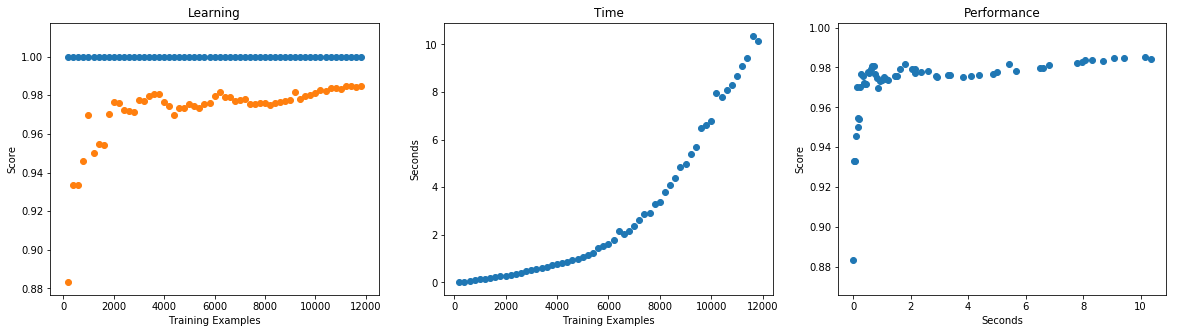

In [39]:
figure, (ax1,ax2,ax3)  = plt.subplots(1,3,figsize=(20,5))

ax1.scatter(interval, scores_t)
ax1.scatter(interval, scores_cv)
ax1.set_title('Learning')
ax1.set_xlabel('Training Examples')
ax1.set_ylabel('Score')

ax2.scatter(interval, times)
ax2.set_title('Time')
ax2.set_xlabel('Training Examples')
ax2.set_ylabel('Seconds')

ax3.scatter(times, scores_cv)
ax3.set_title('Performance')
ax3.set_xlabel('Seconds')
ax3.set_ylabel('Score')

plt.show()

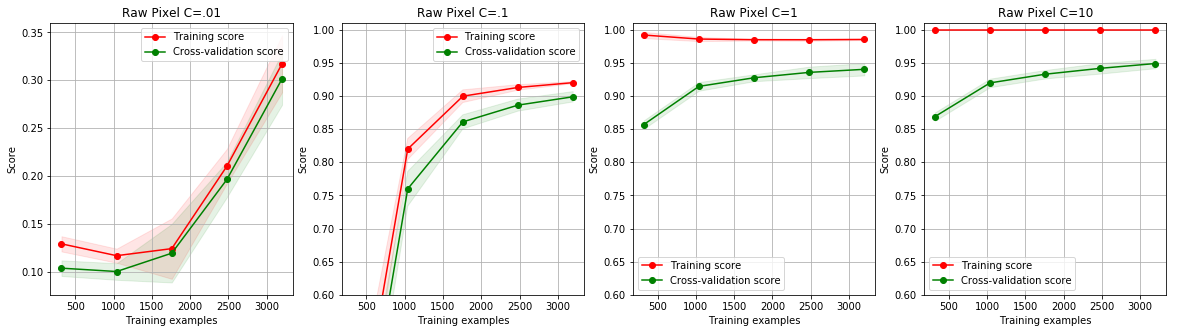

In [49]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

fig, axes = plt.subplots(1, 4,figsize=(20, 5))



title = r"Raw Pixel C=.01"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(C=.01)
plot_learning_curve(estimator, title, training_data, training_labels, axes=axes[0],
                    cv=cv, n_jobs=-1)

title = r"Raw Pixel C=.1"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(C=.1)
plot_learning_curve(estimator, title, training_data, training_labels, axes=axes[1], ylim=(0.6, 1.01),
                    cv=cv, n_jobs=-1)


title = r"Raw Pixel C=1"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(C=1)
plot_learning_curve(estimator, title, training_data, training_labels, axes=axes[2], ylim=(0.6, 1.01),
                    cv=cv, n_jobs=-1)

title = r"Raw Pixel C=10"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(C=10)
plot_learning_curve(estimator, title, training_data, training_labels, axes=axes[3], ylim=(0.6, 1.01),
                    cv=cv, n_jobs=-1)

plt.show()

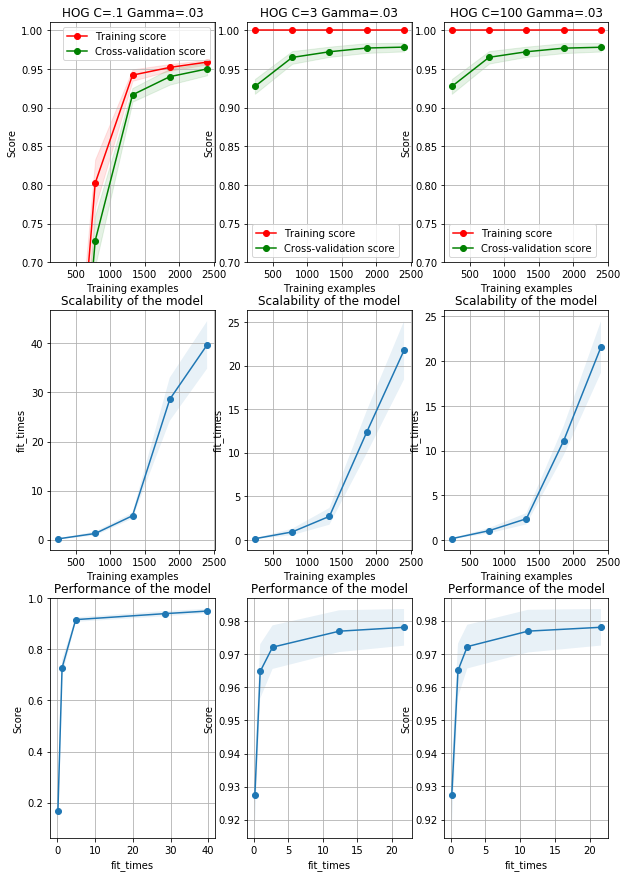

In [35]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

fig, axes = plt.subplots(3, 3, figsize=(10, 15))



title = r"HOG C=.1 Gamma=.03"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(C=.1,gamma=0.03,kernel='rbf')
plot_learning_curve(estimator, title, training_data_hog, training_labels, axes=axes[:, 0],ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

title = r"HOG C=3 Gamma=.03"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(C=3,gamma=0.03,kernel='rbf')
plot_learning_curve(estimator, title, training_data_hog, training_labels, axes=axes[:, 1],ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

title = r"HOG C=100 Gamma=.03"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(C=100,gamma=0.03,kernel='rbf')
plot_learning_curve(estimator, title, training_data_hog, training_labels, axes=axes[:, 2],ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

plt.show()

# ------------------------------------------------------------------------------------------------------------

In [6]:
acc_total = []
interval = [500,1000,5000,10000,15000,20000,25000,30000,35000,40000]
for i in interval:
    print(i)
    train_end = int(i*.7)
    acc = []
    for j in range(3):
        rand_idx = np.arange(data.shape[0])
        np.random.shuffle(rand_idx)

        training_data = data[rand_idx][0:train_end]
        training_data_hog = hog_extract(training_data,9,(4,4),(2,2),'L2')
        training_labels = labels[rand_idx][0:train_end]

        testing_data = data[rand_idx][train_end:i]
        testing_data_hog = hog_extract(testing_data,9,(4,4),(2,2),'L2')
        testing_labels = labels[rand_idx][train_end:i]

        #X_train = training_data
        X_train = training_data_hog
        y_train = training_labels

        #X_test = testing_data
        X_test = testing_data_hog
        y_test = testing_labels

        model = SVC(C=3,gamma=0.03,kernel='rbf')
        #model = SVC(C=3)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        acc.append(metrics.accuracy_score(y_test, y_pred))
    acc_total.append(acc)

500
1000
5000
10000
15000
20000
25000
30000
35000
40000


In [30]:
fmt="g"
row = np.array(interval).reshape(10,1)
header = ['Size','Test 1','Test 2','Test 3',]
mat = np.hstack((row,np.array(acc_total)))

col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
for x in header:
    print(x,end="    ")
print("")
for x in mat:
    for i, y in enumerate(x):
        print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
    print("")

Size    Test 1    Test 2    Test 3    
  500  0.953333      0.98  0.946667  
 1000      0.96  0.976667      0.94  
 5000  0.976667  0.979333      0.97  
10000  0.981667     0.981  0.981667  
15000  0.983778  0.984667  0.981556  
20000  0.986333  0.984833  0.986667  
25000  0.987333     0.988  0.986267  
30000  0.984556  0.987889  0.987111  
35000     0.988   0.98581  0.987619  
40000  0.987917   0.98725   0.98725  


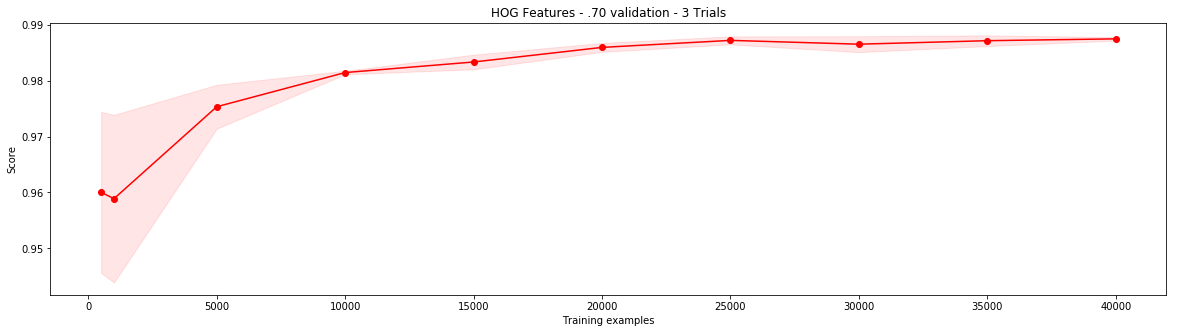

In [32]:
train_scores_mean = np.mean(acc_total, axis=1)
train_scores_std = np.std(acc_total, axis=1)

fig, axes = plt.subplots(1,1,figsize=(20, 5))
axes.grid()
axes.set_title(r"HOG Features - .70 validation - 3 Trials")
axes.set_xlabel("Training examples")
axes.set_ylabel("Score")
axes.grid()
axes.fill_between(interval, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
axes.plot(interval, train_scores_mean, 'o-', color="r")

In [9]:
model = SVC(C=3,gamma=0.03,kernel='rbf')
#model = SVC(C=.1,kernel='linear')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [12]:
print("Accuracy: "+str(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred,digits=5))

miss = testing_data[testing_labels != y_pred]

print(miss.shape)

Accuracy: 0.9782539682539683
              precision    recall  f1-score   support

         0.0    0.98336   0.99121   0.98727      1252
         1.0    0.98361   0.98996   0.98677      1394
         2.0    0.97389   0.98244   0.97815      1253
         3.0    0.97469   0.96215   0.96838      1321
         4.0    0.97349   0.97979   0.97663      1237
         5.0    0.97511   0.97252   0.97381      1128
         6.0    0.98979   0.99369   0.99174      1268
         7.0    0.97623   0.97548   0.97585      1305
         8.0    0.98013   0.96970   0.97489      1221
         9.0    0.97112   0.96396   0.96753      1221

    accuracy                        0.97825     12600
   macro avg    0.97814   0.97809   0.97810     12600
weighted avg    0.97824   0.97825   0.97823     12600

(274, 784)


In [62]:
picture = []
for i in miss:
    image = i.reshape(28,28)
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    image8bit = cv2.resize(image8bit,(64,64))
    picture.append(image8bit)
write_image('outliers.jpg',np.vstack((np.hstack(np.array(picture)[0:10]),
                                      np.hstack(np.array(picture)[10:20]),
                                      np.hstack(np.array(picture)[20:30]),
                                      np.hstack(np.array(picture)[40:50]),
                                      np.hstack(np.array(picture)[50:60]),
                                      np.hstack(np.array(picture)[60:70])
                                     )))

In [17]:
#load test
data_path = os.path.join('C:/Users/Brett/Documents/CISC484/data/','test.csv')
test = np.loadtxt(data_path, delimiter=',',skiprows=1)

In [10]:
test_hog = hog_extract(test,9,(4,4),(2,2),'L2')

In [18]:
test_pred = model.predict(test)

In [19]:
final = np.hstack((np.arange(1,28001).reshape(28000,1),test_pred.astype(int).reshape(28000,1))).astype(int)

In [20]:
np.savetxt('submission.csv',final,delimiter=",",fmt='%s')

# ------------------------------------------------------------------------------------------------------------

In [6]:
n = 30000

rand_idx = np.arange(data.shape[0])
np.random.shuffle(rand_idx)

training_data = data[rand_idx][0:n]
X_train = hog_extract(training_data,9,(4,4),(2,2),'L2')
y_train = labels[rand_idx][0:n]

testing_data = data[rand_idx][n:40000]
X_test = hog_extract(testing_data,9,(4,4),(2,2),'L2')
y_test = labels[rand_idx][n:40000]

In [83]:
list1 = []
list2 = []
n = 50
for i in range(10):
    subset = X_train[np.where(y_train == i)]
    kmeans = KMeans(n_clusters=1).fit(subset)
    dist_matrix = kmeans.transform(subset)
    dist_sort_idx = np.argsort(dist_matrix,axis=0)[::-1][0:n].flatten()
    list1.append([subset[dist_sort_idx]])
    list2.append(np.full(n,i,dtype=int))
X_reduced = np.array(listt).reshape(500,1296)
y_reduced = np.array(list2).reshape(500,)

C:\Users\Brett\anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  f"KMeans is known to have a memory leak on Windows "
C:\Users\Brett\anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  f"KMeans is known to have a memory leak on Windows "
C:\Users\Brett\anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  f"KMeans 

In [84]:
y_reduced.shape

(500,)

In [ ]:
kmeans = KMeans(n_clusters=10).fit(X_train)
X_kmeans = np.vstack((X_train,kmeans.cluster_centers_))
X_tsne = manifold.TSNE(n_components=3,perplexity=25).fit_transform(X_kmeans)
dist_matrix = kmeans.transform(X_train)

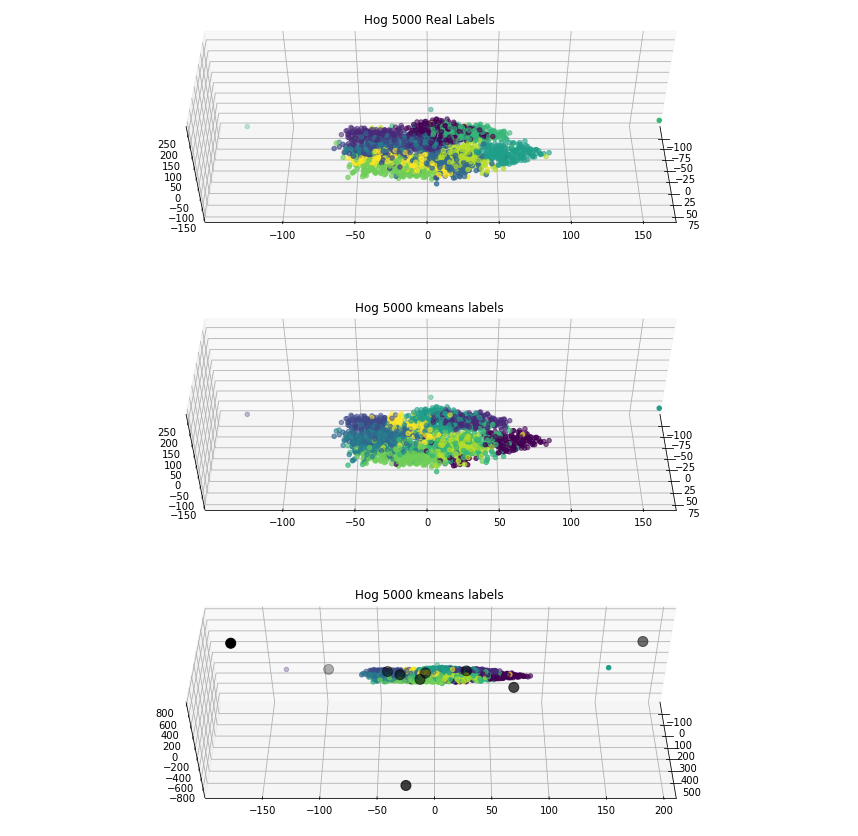

In [270]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(3, 1, 1, projection='3d')
ax1.scatter(X_tsne[:-10,0], X_tsne[:-10,1],X_tsne[:-10,2],c=y_train)
ax1.set_title('Hog 5000 Real Labels')
ax1.view_init(45,0)


ax2 = fig.add_subplot(3, 1, 2, projection='3d')
ax2.scatter(X_tsne[:-10,0], X_tsne[:-10,1],X_tsne[:-10,2],c=kmeans.labels_)
ax2.set_title('Hog 5000 kmeans labels')
ax2.view_init(45,0)

ax3 = fig.add_subplot(3, 1, 3, projection='3d')
ax3.scatter(X_tsne[:-10,0], X_tsne[:-10,1],X_tsne[:-10,2],c=kmeans.labels_)
ax3.scatter(X_tsne[-10:,0], X_tsne[-10:,1],X_tsne[-10:,2],color='k',s=100)
ax3.set_title('Hog 5000 kmeans labels')
ax3.view_init(45,0)


plt.show()

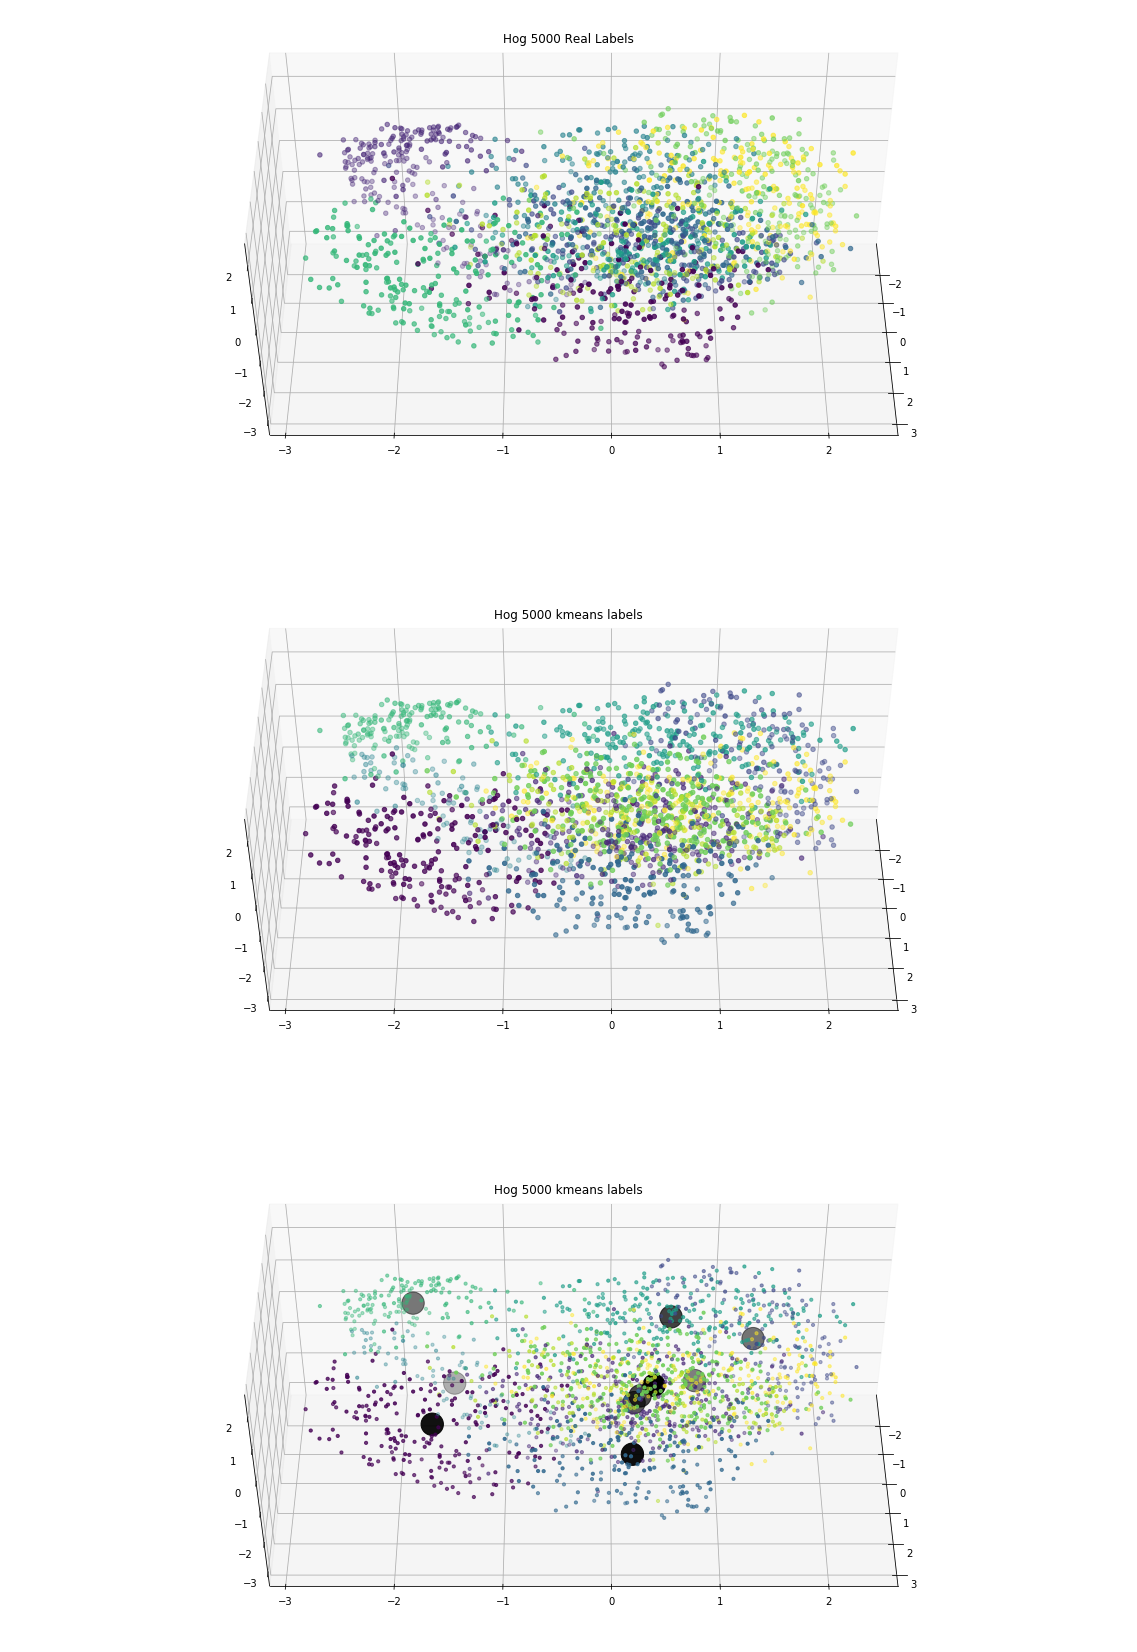

In [231]:
X_pca = pca(X_kmeans,3)

fig = plt.figure(figsize=(20,30))

ax1 = fig.add_subplot(3, 1, 1, projection='3d')
ax1.scatter(X_pca[:-10,0], X_pca[:-10,1],X_pca[:-10,2],c=y_train)
ax1.set_title('Hog 5000 Real Labels')
ax1.view_init(45,0)


ax2 = fig.add_subplot(3, 1, 2, projection='3d')
ax2.scatter(X_pca[:-10,0], X_pca[:-10,1],X_pca[:-10,2],c=kmeans.labels_)
ax2.set_title('Hog 5000 kmeans labels')
ax2.view_init(45,0)

ax2 = fig.add_subplot(3, 1, 3, projection='3d')
ax2.scatter(X_pca[:-10,0], X_pca[:-10,1],X_pca[:-10,2],c=kmeans.labels_ ,s=10)
ax2.set_title('Hog 5000 kmeans labels')
ax2.view_init(45,0)
ax2.scatter(X_pca[-10:,0], X_pca[-10:,1],X_pca[-10:,2],color='k',s=500)

plt.show()

In [245]:
mean = np.mean(dist_matrix,axis=0)
s = np.std(dist_matrix,axis=0)

max_dist = mean+s

idx = np.all((max_dist-dist_matrix)>0, axis=1)
X_reduced = X_train[idx]
y_reduced = y_train[idx]
print(X_reduced.shape)
unique, counts = np.unique(y_reduced, return_counts=True)
print("\nNumber\tCount")
for d, c in zip(unique, counts):
    print("{0}\t{1}".format(int(d),c))

(952, 1296)

Number	Count
0	66
1	166
2	57
3	114
4	81
5	56
6	52
7	50
8	151
9	159


In [275]:
sums_idx = np.argsort(np.sum(dist_matrix,axis=1))[::-1]
X_reduced = X_train[sums_idx][0:500]
y_reduced = y_train[sums_idx][0:500]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 20000 but corresponding boolean dimension is 2000

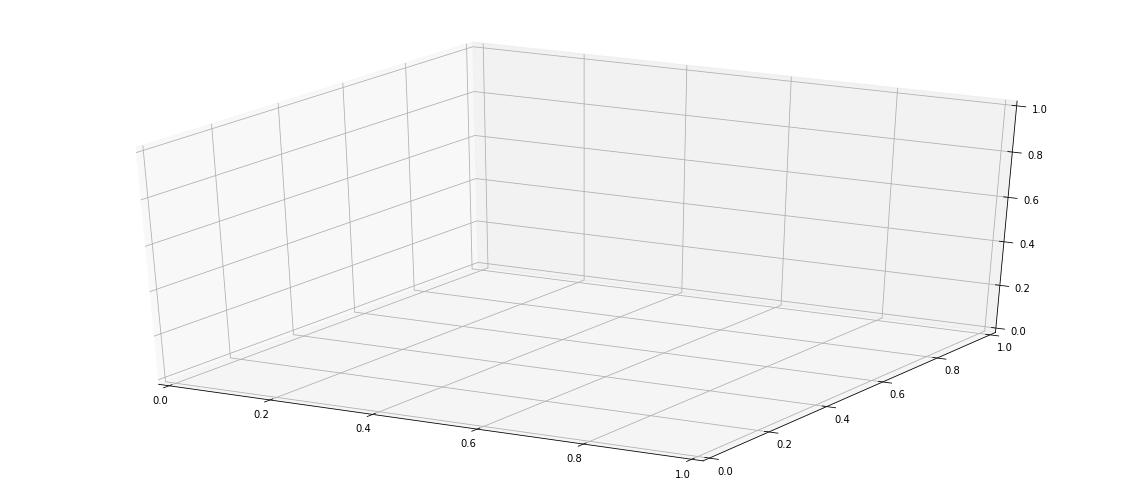

In [276]:
fig = plt.figure(figsize=(20,30))

ax2 = fig.add_subplot(3, 1, 3, projection='3d')
ax2.scatter(X_pca[:-10,0][idx], X_pca[:-10,1][idx],X_pca[:-10,2][idx],c=kmeans.labels_[idx] ,s=10)
ax2.set_title('Hog 5000 kmeans labels')
ax2.view_init(45,0)
ax2.scatter(X_pca[-10:,0], X_pca[-10:,1],X_pca[-10:,2],color='k',s=500)

plt.show()

In [ ]:
model = SVC(C=3,gamma=0.03,kernel='rbf')
model.fit(X_reduced,y_reduced)
y_pred = model.predict(X_test[:X_reduced.shape[0]])
print("Accuracy: "+str(metrics.accuracy_score(y_test[:X_reduced.shape[0]], y_pred)))
print(metrics.classification_report(y_test[:X_reduced.shape[0]], y_pred,digits=5))

In [267]:
model = SVC(C=3,gamma=0.03,kernel='rbf')
model.fit(X_train[:X_reduced.shape[0]],y_train[:X_reduced.shape[0]])
y_pred = model.predict(X_test[:X_reduced.shape[0]])
print("Accuracy: "+str(metrics.accuracy_score(y_test[:X_reduced.shape[0]], y_pred)))
print(metrics.classification_report(y_test[:X_reduced.shape[0]], y_pred,digits=5))

Accuracy: 0.946
              precision    recall  f1-score   support

         0.0    0.97917   0.97917   0.97917        48
         1.0    0.94643   0.96364   0.95495        55
         2.0    0.87805   0.87805   0.87805        41
         3.0    0.93478   0.89583   0.91489        48
         4.0    0.96154   0.96154   0.96154        52
         5.0    0.96226   0.92727   0.94444        55
         6.0    0.96667   1.00000   0.98305        58
         7.0    0.94000   0.95918   0.94949        49
         8.0    0.90196   0.95833   0.92929        48
         9.0    0.97674   0.91304   0.94382        46

    accuracy                        0.94600       500
   macro avg    0.94476   0.94361   0.94387       500
weighted avg    0.94640   0.94600   0.94589       500

